In [226]:
import numpy as np
import pandas as pd
import scipy as sp
import plotly.express as px
import networkx as nx
import degroot as dg
from tqdm import tqdm
import plotly.graph_objects as go
from joblib import Parallel, delayed

In [227]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [228]:
# Parameters
dims = 8
erdos_reni_p = 0.3
n_initial_conditions_attempts = 100
max_edge_value = 5
init_belief = np.random.rand(dims) # np.random.randint(0,2, size=dims).astype(float) # Random initial belief
correct_belief = 0.8
niter_degroot = 2
niter_search = 100
symmetric = False

In [229]:
def generate_initial_conditions(n: int, p: float, n_attempts: int):
    initial_conditions = []
    for i in range(n_attempts):
        m = nx.adjacency_matrix(nx.erdos_renyi_graph(n=n, p=p)).todense()
        if np.min(np.sum(m, axis=1)) == 0 or np.max(np.sum(m, axis=1)) == n-1:
            continue
            
        m = np.random.randint(1, max_edge_value + 1, size=(n, n)) * m
        initial_conditions.append(m)
    
    unique_initial_conditions = np.unique([s.flatten() for s in initial_conditions], axis=0)
    unique_initial_conditions = [s.reshape(dims, dims) for s in unique_initial_conditions]
    print('Number of unique initial conditions:', len(unique_initial_conditions))
    return unique_initial_conditions

In [230]:
def generate_initial_conditions_fixed_graph(n: int, p: float, n_attempts: int):
    m_base = nx.adjacency_matrix(nx.erdos_renyi_graph(n=n, p=p)).todense()
    while np.min(np.sum(m_base, axis=1)) == 0 or np.max(np.sum(m_base, axis=1)) == n-1:
        m_base = nx.adjacency_matrix(nx.erdos_renyi_graph(n=n, p=p)).todense()
    
    
    initial_conditions = []
    for _ in range(n_attempts):
        m = m_base.copy()
        for i in range(n):
            np.random.shuffle(m[i])
            
            if m[i, i] == 1:
                j = np.random.randint(0, n)
                while m[i, j] == 1:
                    j = np.random.randint(0, n)
            
                m[i, j] = 1
                m[i, i] = 0
                
            
        m = np.random.randint(1, max_edge_value + 1, size=(n, n)) * m
        initial_conditions.append(m)
    
    unique_initial_conditions = np.unique([s.flatten() for s in initial_conditions], axis=0)
    unique_initial_conditions = [s.reshape(dims, dims) for s in unique_initial_conditions]
    print('Number of unique initial conditions:', len(unique_initial_conditions))
    return unique_initial_conditions

In [231]:
init_cond = generate_initial_conditions(n=dims, p=erdos_reni_p, n_attempts=n_initial_conditions_attempts)

Number of unique initial conditions: 48


In [232]:
results = Parallel(n_jobs=-1)(delayed(dg.myopic_search)(m0=x, niter_search=niter_search, max_edge_value=max_edge_value, initial_belief=init_belief, correct_belief=correct_belief, niter_degroot=niter_degroot, symmetric=symmetric)  for x in tqdm(init_cond))

100%|██████████| 48/48 [00:01<00:00, 27.02it/s]


In [233]:
meta_data = pd.DataFrame([{'final_error': r.error, 'initial_error': r.initial_error, 'converged': r.converged, 'iterations': r.iterations, 'num': i} for i, r in enumerate(results)])
px.scatter(meta_data, x='initial_error', y='final_error', color='converged', hover_data=['num'])

In [234]:
px.histogram(meta_data, x='iterations', color='converged')

In [235]:
flat_solutions = np.array([r.m.flatten() for r in results])
dist = sp.spatial.distance.pdist(flat_solutions, metric='hamming')
hist, bins = np.histogram(dist, bins=dims)
px.scatter(x=bins[1:], y=hist)

In [236]:
influence = []
for r in results:
    sol = r.m / np.sum(r.m, axis=1)[:, None]
    influence_ = np.sum(sol, axis=0)
    influence.append(influence_)
    
influence_mean = np.mean(influence, axis=0)
influence_std = np.std(influence, axis=0)
influence_ci = 1.96 * influence_std / np.sqrt(len(influence))
px.scatter(x=np.abs(init_belief-correct_belief), y=influence_mean, error_y=influence_std, labels={'x': 'Initial error', 'y': 'Influence'})

In [237]:
belief_evol = []
did_not_converge = 0
total = 0
for i, r in enumerate(results):
    for t in r.trajectory:
        total += 1
        belief = r.trajectory[t]['final_belief']
        if np.max(sp.spatial.distance.pdist(belief.reshape(-1,1), metric='euclidean')) > 1e-5:
            did_not_converge += 1

        belief_evol.append({'belief': np.mean(belief), 'result': f'Res{i}', 'iteration': t})

print('Did not converge share:', did_not_converge / total)
belief_evol = pd.DataFrame(belief_evol).sort_values('belief', ascending=False)
fig = px.scatter(belief_evol, x='iteration', y='belief', color='result', render_mode='svg')
fig.add_trace(go.Scatter(x=[0, belief_evol['iteration'].max()], y=[correct_belief, correct_belief], mode='lines', name='Correct belief'))
fig.show()

Did not converge share: 1.0


In [238]:
len(np.unique(flat_solutions, axis=0))

48

0.2886497278953548 True


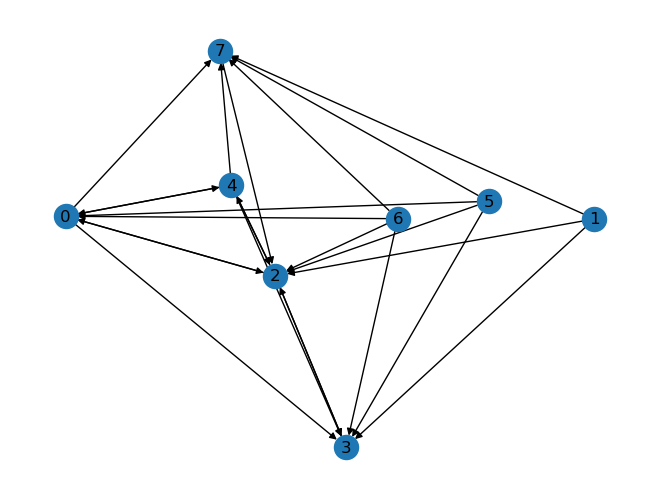

In [239]:
r = results[26]
g = nx.from_numpy_array(r.m, create_using=nx.DiGraph)
print(r.error, r.converged)
pos = nx.spring_layout(g)
nx.draw(g, pos, with_labels=True)

In [240]:
pd.DataFrame({'initial_belief': init_belief, 'correct_belief': correct_belief, 'diff': np.abs(init_belief-correct_belief), 'node': np.arange(dims)}).sort_values('diff')

,initial_belief,correct_belief,diff,node
4,0.554501,0.8,0.245499,4
2,0.538159,0.8,0.261841,2
3,0.438621,0.8,0.361379,3
0,0.345928,0.8,0.454072,0
7,0.220001,0.8,0.579999,7
5,0.212878,0.8,0.587122,5
1,0.163626,0.8,0.636374,1
6,0.053855,0.8,0.746145,6
